Additional installs: 

- conda install seaborn
- conda install mapclassify
- conda install libpysal
- conda install esda



Inspiration: 
- https://github.com/geopandas/scipy2018-geospatial-data/blob/master/06-exploratory-spatial-data-analysis.ipynb
- https://github.com/pysal/scipy2019-intermediate-gds/blob/master/notebooks/gds5-exploration.ipynb    

In [88]:
import os
import urllib

import geopandas as gpd# to read/write spatial data
import pandas as pd# to read/write plain tables
import numpy as np
import shapely

import libpysal as lp
import esda 
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt # to visualize data
import matplotlib.transforms as transforms
from matplotlib import colors

import seaborn as sbn

datapath = "data/autocorrel"
outputpath="output/autocorrel"

In [89]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [90]:
def download_if_nexist(url, filename):
    """
    If the (local) file <filename> does not exists, download it from <url> 

    Parameters
    ----------
    url: str
       url to fetch
    filename: str
       local file to save

    Returns
    -------

    None
    """
    if not os.path.isfile(filename):
        with urllib.request.urlopen(url) as response:
            with open(filename, "wb") as f:
                f.write(response.read())

In [91]:
%matplotlib inline

# Data load

In [92]:
os.makedirs(datapath,   exist_ok=True)
os.makedirs(outputpath, exist_ok=True)

## Statistical sectors

We first load the geographical definitions of statistical sectors, from StatBel. By aggregating the on "CNIS5_2020" (NIS code of a commune), we obtain commune boundaries

In [93]:
download_if_nexist("https://statbel.fgov.be/sites/default/files/files/opendata/Statistische%20sectoren/sh_statbel_statistical_sectors_31370_20200101.shp.zip",
                   f"{datapath}/stat_sectors_2020.zip")

statistical_sectors = gpd.read_file(f"zip://{datapath}/stat_sectors_2020.zip/sh_statbel_statistical_sectors_20200101.shp")
statistical_sectors["CNIS5_2020"] = statistical_sectors["CNIS5_2020"].astype(str)
# statistical_sectors = statistical_sectors.to_crs(osm_crs)
statistical_sectors.columns= statistical_sectors.columns.str.lower()
# statistical_sectors

In [148]:
# Get commune boundaries from statistical sector boundaries
sectors = statistical_sectors[["cnis5_2020", "geometry", "t_mun_fr"]].dissolve("cnis5_2020")
sectors = sectors.reset_index().rename({"cnis5_2020": "code", "t_mun_fr": "name"}, axis=1)
sectors.head()

code                                           geometry        name
0  11001  POLYGON Z ((150146.614 200004.830 0.000, 15004...  Aartselaar
1  11002  POLYGON Z ((150427.738 203934.363 0.000, 15042...      Anvers
2  11004  POLYGON Z ((160710.892 204171.221 0.000, 16070...    Boechout
3  11005  POLYGON Z ((151375.980 197079.947 0.000, 15137...        Boom
4  11007  POLYGON Z ((159339.112 209024.062 0.000, 15932...    Borsbeek

In [95]:
# Get province bounds (for visualisation purpose only)
extra_bounds = statistical_sectors[["t_provi_fr", "geometry"]].dissolve("t_provi_fr")
extra_bounds

geometry
t_provi_fr                                                                        
Province de Flandre occidentale  POLYGON Z ((83489.530 159995.491 0.000, 83488....
Province de Flandre orientale    POLYGON Z ((98736.032 158867.058 0.000, 98719....
Province de Liège                POLYGON Z ((276506.515 96694.991 0.000, 276514...
Province de Namur                POLYGON Z ((193240.987 54915.334 0.000, 193226...
Province du Brabant flamand      POLYGON Z ((126516.330 154035.693 0.000, 12651...
Province du Brabant wallon       POLYGON Z ((150959.609 139257.480 0.000, 15088...
Province du Hainaut              MULTIPOLYGON Z (((154103.564 70323.214 0.000, ...
Province du Limbourg             MULTIPOLYGON Z (((205615.858 154477.589 0.000,...
Province du Luxembourg           POLYGON Z ((234354.943 23041.209 0.000, 234310...
Province d’Anvers                MULTIPOLYGON Z (((158434.326 187398.708 0.000,...

<AxesSubplot:>

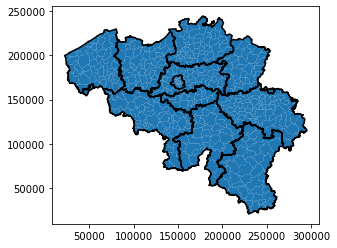

In [96]:
ax = sectors.plot()
extra_bounds.boundary.plot(ax=ax, color='k')

## Values

### Area

In [97]:
area = sectors[["code", "geometry"]]#.area

area["area"] = area.area/10**6
area = area[["code", "area"]]

### Cars per households

In [98]:
download_if_nexist("https://statbel.fgov.be/sites/default/files/files/opendata/Aantal%20wagens%20per%20statistische%20sector/TF_CAR_HH_SECTOR.xlsx",
                   f"{datapath}/TF_CAR_HH_SECTOR.xlsx")

In [99]:
car_per_hh = pd.read_excel(f"{datapath}/TF_CAR_HH_SECTOR.xlsx")
car_per_hh = car_per_hh.groupby("CD_REFNIS")[["MS_NUM_HH", "MS_NUM_CAR"]].sum().reset_index()
car_per_hh["car_per_hh"] = car_per_hh.MS_NUM_CAR / car_per_hh.MS_NUM_HH
car_per_hh = car_per_hh[["CD_REFNIS", "car_per_hh"]].rename(columns={"CD_REFNIS": "code"})
car_per_hh["code"] = car_per_hh["code"].astype(str)


### Income


In [100]:
download_if_nexist("https://statbel.fgov.be/sites/default/files/files/documents/Huishoudens/10.9%20Fiscale%20inkomens/fisc2018_C_FR.xls",
                   f"{datapath}/fisc_income.xls")

In [101]:
income = pd.read_excel(f"{datapath}/fisc_income.xls", sheet_name="par décl. indiv.", skiprows=6)
income = income.rename(columns={"Unnamed: 1":"code", 
                                "Revenu médian par déclaration": "median_income",
                                "Revenu moyen par déclaration": "mean_income"})
income = income[["code", "median_income", "mean_income"]]
income = income[income.code.notnull()]
income["code"] = income["code"].astype(int).astype(str)
# income

In [102]:
# income[income.median_income.isnull()]

### Census

In [103]:
# Data from https://www.census2011.be/
download_if_nexist("https://visuals.statbel.fgov.be/visuals/data/census.csv", 
                   f"{datapath}/census.csv")

In [104]:
census= pd.read_csv(f"{datapath}/census.csv", sep=";",  decimal=",")
census = census.rename(columns={"Geography": "code", "Older than 20 with high degree": "with_degree"})

census["code"] = census["code"].astype(str)
#census["avg_age"] = census["avg_age"].astype(float)

census_fields = ["with_degree"]
census = census[["code"] + census_fields]

In [105]:
# Census is older then the last commune fusions. Need some adjustments 
code_changes= {
    "55022": "58001",
    "56011": "58002",
    "56085": "58003",
    "56087": "58004",
    "52063": "55085",
    "52043": "55086",
    "55010": "51067",
    "55039": "51068",
    "55023": "51069",
    "54007": "57096",
    "54010": "57097"
}

In [106]:
code_fusions = {
    "72042": ["72040", "71047"],       # Meeuwen-Gruitrode et Opglabbeek: Code INS 72042 (nouveau nom : Oudsbergen)
    "72043": ["72025", "72029"],       # Neerpelt et Overpelt: Code INS 72043 (nouveau nom : Pelt)
    "45068": ["45017", "45057"],       # Kruishoutem et Zingem: Code INS 45068 (nouveau nom : Kruisem)
    "44084": ["44029", "44001"],       # Aalter et Knesselare: Code INS 44084 (nouveau nom : Aalter)
    "44083": ["44049", "44011"],       # Deinze et Nevele: Code INS 44083 (nouveau nom : Deinze)
    "12041": ["12030", "12034"],       # Puurs et Sint-Amands: Code INS 12041 (nouveau nom : Puurs-Sint-Amands)
    "44085": ["44072", "44036", "44080"]  # Waarschoot, Lovendegem & Zomergem: Code INS 44085 (nouveau nom : Lievegem)
}

In [107]:
for new_code in code_fusions:
    new_rec = census[census.code.isin(code_fusions[new_code])][census_fields].mean()
    new_rec["code"] = new_code
    census = census[~census.code.isin(code_fusions[new_code])]
    
    census = census.append(new_rec, ignore_index=True)
    

In [108]:
census["code"] = census.code.replace(code_changes)

In [109]:
with_degree=census[["code", "with_degree"]]

### Random

In [110]:
random1 = sectors[["code"]].copy()
random1["random1"] = np.random.randint(1, 1000, random1.shape[0])/1000


In [111]:
random2 = sectors[["code"]].copy()
random2["random2"] = np.random.randint(1, 1000, random2.shape[0])/1000


### Merge

In [146]:
data = sectors.fillna(0).merge(car_per_hh).merge(area).merge(random1).merge(random2).merge(with_degree, how="left").merge(income, how="left")
# data_columns = ["accid_per_km2", "car_per_hh", "area", "random1", "random2", "with_degree", "median_income"]
data_columns = ["car_per_hh", "area", "random1", "random2", "with_degree", "median_income", "mean_income"]
#data_columns = ["random1", "random2", "accid_per_km2"]


data.head()

code                                           geometry        name  \
0  11001  POLYGON Z ((150146.614 200004.830 0.000, 15004...  Aartselaar   
1  11002  POLYGON Z ((150427.738 203934.363 0.000, 15042...      Anvers   
2  11004  POLYGON Z ((160710.892 204171.221 0.000, 16070...    Boechout   
3  11005  POLYGON Z ((151375.980 197079.947 0.000, 15137...        Boom   
4  11007  POLYGON Z ((159339.112 209024.062 0.000, 15932...    Borsbeek   

   car_per_hh        area  random1  random2  with_degree  median_income  \
0    1.337847   11.019132    0.498    0.578       0.3474        21966.0   
1    0.737829  204.319831    0.095    0.718       0.2564        18417.0   
2    1.259911   20.708315    0.351    0.074       0.3782        20091.0   
3    1.045719    7.382118    0.683    0.973       0.2092        19088.0   
4    1.022124    3.901369    0.287    0.161       0.2483        20257.0   

   mean_income  
0      25191.0  
1      21707.0  
2      23442.0  
3      21716.0  
4      22653.0

# Bivariate (classical) correlations 

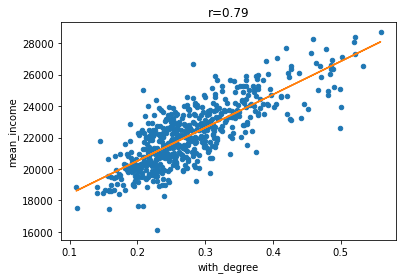

In [113]:
c1= "with_degree"
c2= "mean_income"

# Compute pearson coeficient
pearson_r = np.corrcoef(data[c1], data[c2])[0][1]

# Plot dots
data.plot.scatter(x=c1, y=c2, title=f"r={pearson_r:.2}")

# Plot regression line
m, b = np.polyfit(data[c1].fillna(0), data[c2].fillna(0), 1)
plt.plot(data[c1].fillna(0), m*data[c1].fillna(0) + b, color="C1")
plt.savefig(f'{outputpath}/correlation.png', dpi=150,  bbox_inches='tight')


# Plot raw data

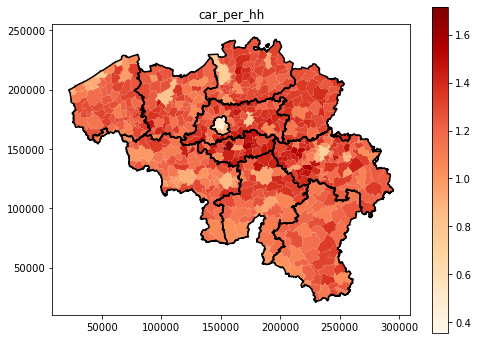

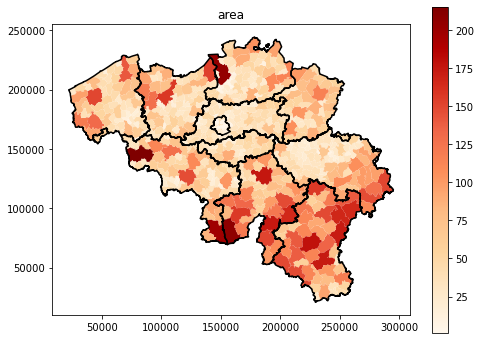

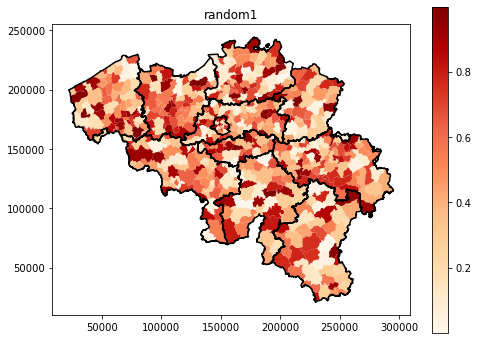

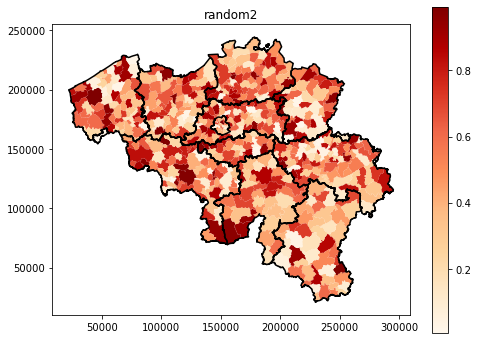

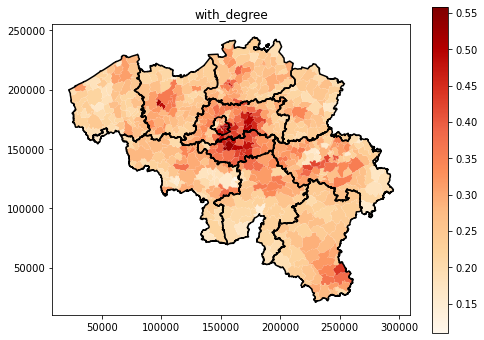

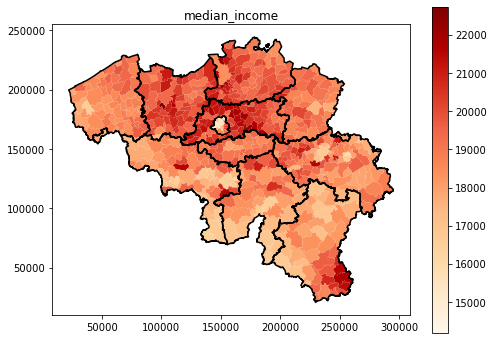

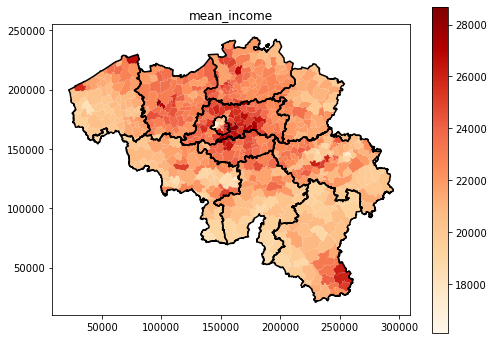

In [145]:
for v in data_columns:
    ax = data.plot(v, missing_kwds=dict(color='grey', label='No Data'), legend=True, figsize=(8,6), cmap="OrRd")
    extra_bounds.boundary.plot(ax=ax, color='k')
    ax.set_title(v)

## Using quantile classification

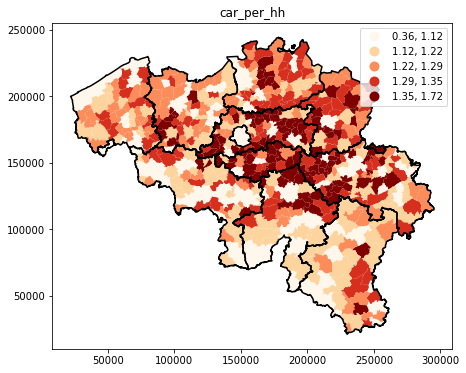

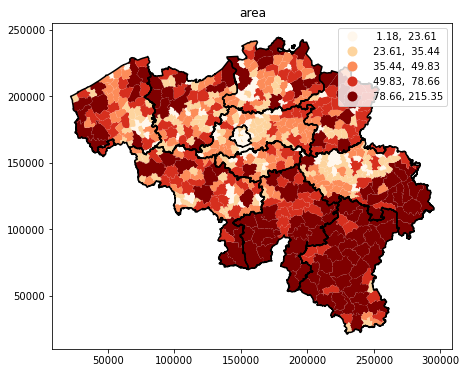

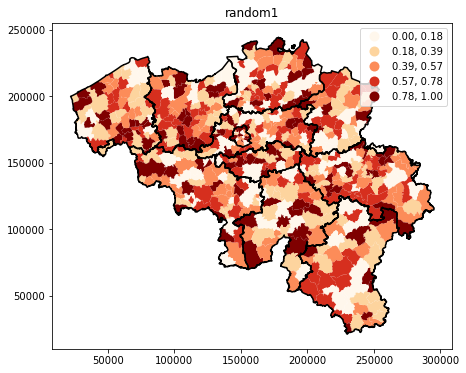

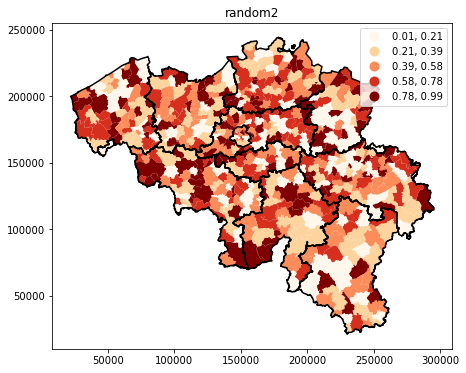

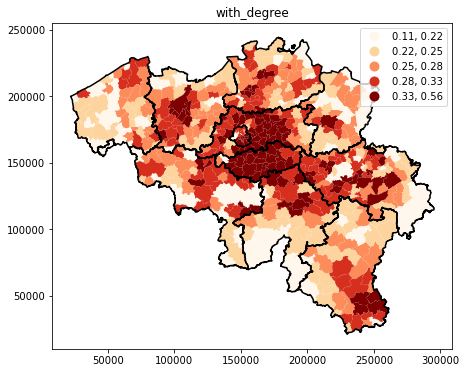

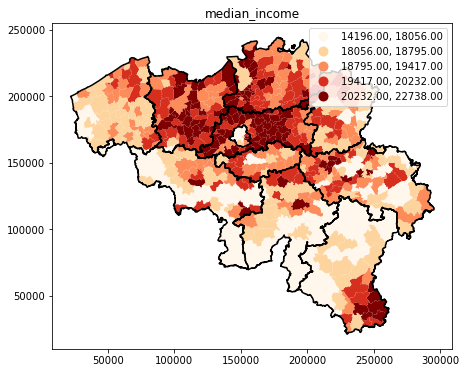

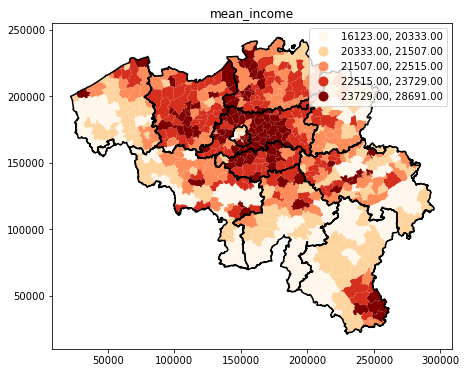

In [144]:
for v in data_columns:
    ax = data.plot(v, legend=True, figsize=(8,6), cmap="OrRd", scheme="quantiles", k=5)
    extra_bounds.boundary.plot(ax=ax, color='k')
    ax.set_title(v)


# Queen neighborhood

Computing spatial autocorrelation requires which sector is close to each each other. Boudaries data we process so far just define commune boundaries as polygons, but do not directly indicates which commune "touches" (even by one single point) which other commune. 

This can be done by the computation of the "Queen neighborhood". Note that this requires good quality polygons. If they overlaps, or have small gaps, queen neighborhood won't work correctly.

In [116]:
wq =  lp.weights.Queen.from_dataframe(data)
wq.transform = 'r'


In [117]:
# Tells which records is neighbor to which other record

{k:wq.neighbors[k] for k in range(5)}

{0: [16, 1, 18, 19, 7, 9, 13],
 1: [0, 4, 5, 7, 297, 298, 9, 12, 15, 21, 22, 23, 24, 28],
 2: [17, 35, 4, 24, 10, 14, 15],
 3: [16, 41, 18, 40],
 4: [24, 1, 2, 15]}

<AxesSubplot:>

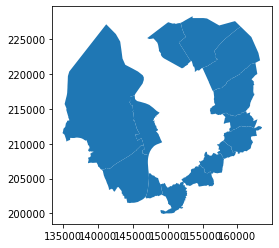

In [118]:
data.loc[wq.neighbors[1]].plot()

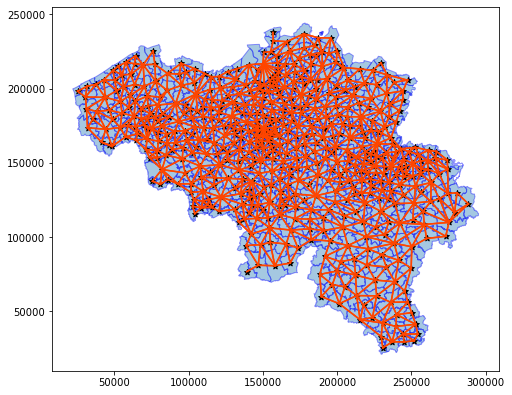

In [119]:
f = plt.figure(figsize=(8,8))
ax = plt.gca()
# when you only want to plot the boundaries:
data.plot( ax=ax, alpha=.4, edgecolor="b")
wq.plot(data, edge_kws=dict(linewidth=1.5, color='orangered'), 
              node_kws=dict(marker='*'), ax=ax)
plt.show()

# Spatial lag

The spatial lag for a sector is average value of all the touching sectors


In [120]:
ylag = {v: lp.weights.lag_spatial(wq, data[v]) for v in data_columns}

In [121]:
# ylag

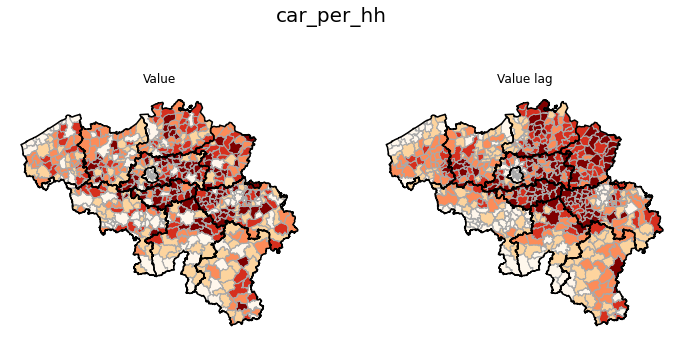

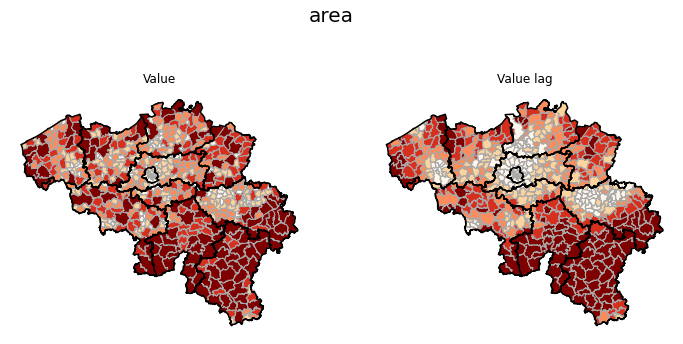

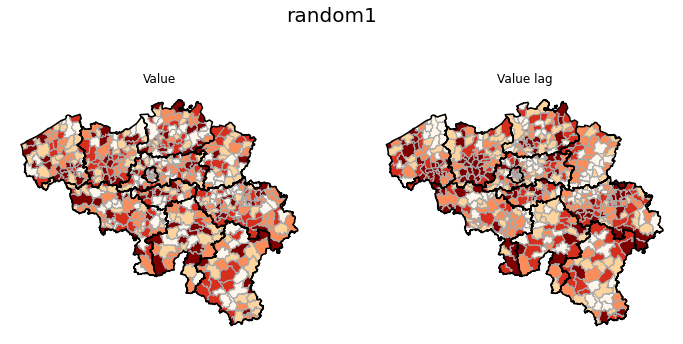

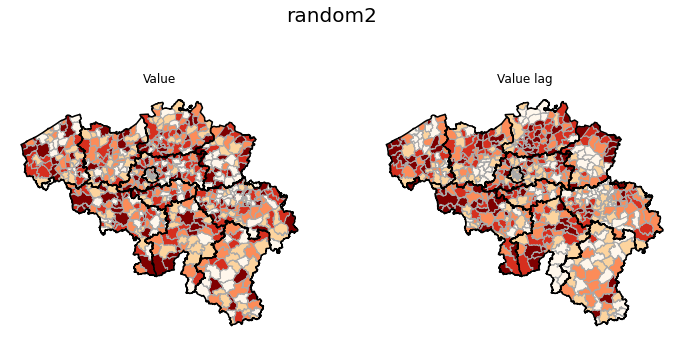

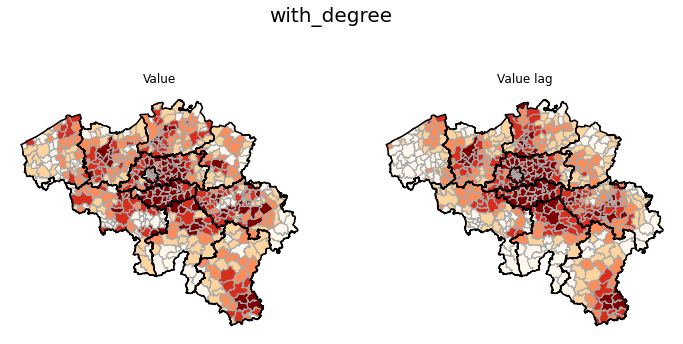

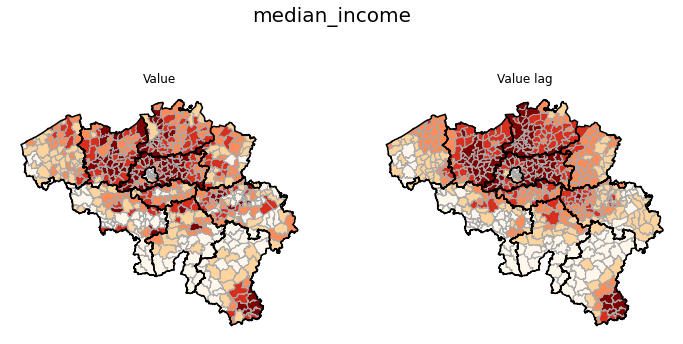

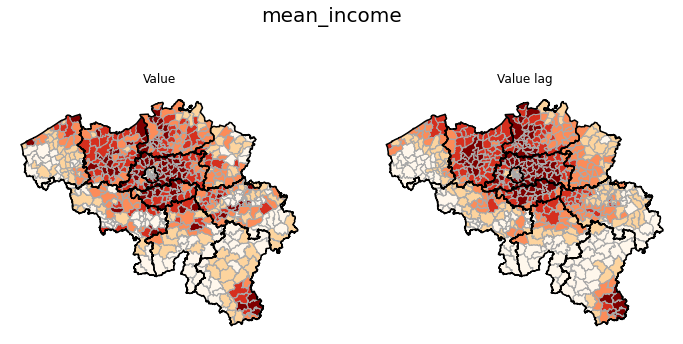

In [143]:
for v in data_columns:
    #f,ax = plt.subplots(1,2,figsize=(20,10))
    f,ax = plt.subplots(1,2,figsize=(12,6)) # Small figs to spare github disk space...
    
    f.suptitle(v, fontsize=20)
    data.plot(v, ax=ax[0], scheme='quantiles',  cmap='OrRd', edgecolor="darkgrey")
    extra_bounds.boundary.plot(ax=ax[0], color='k')
    ax[0].set_title("Value")
    ax[0].axis('off')

    data.assign(lag=ylag[v]).plot("lag", ax=ax[1], scheme='quantiles',  cmap='OrRd', edgecolor="darkgrey")
    extra_bounds.boundary.plot(ax=ax[1], color='k')
    ax[1].set_title("Value lag")
    ax[1].axis('off')

    plt.show()

## Moran's scatterplot

Moran's scatterplot plots for each sector its value on one axis, and its spatial lag on the other axis. It allows to see the correlation between a sector and neighborhood.


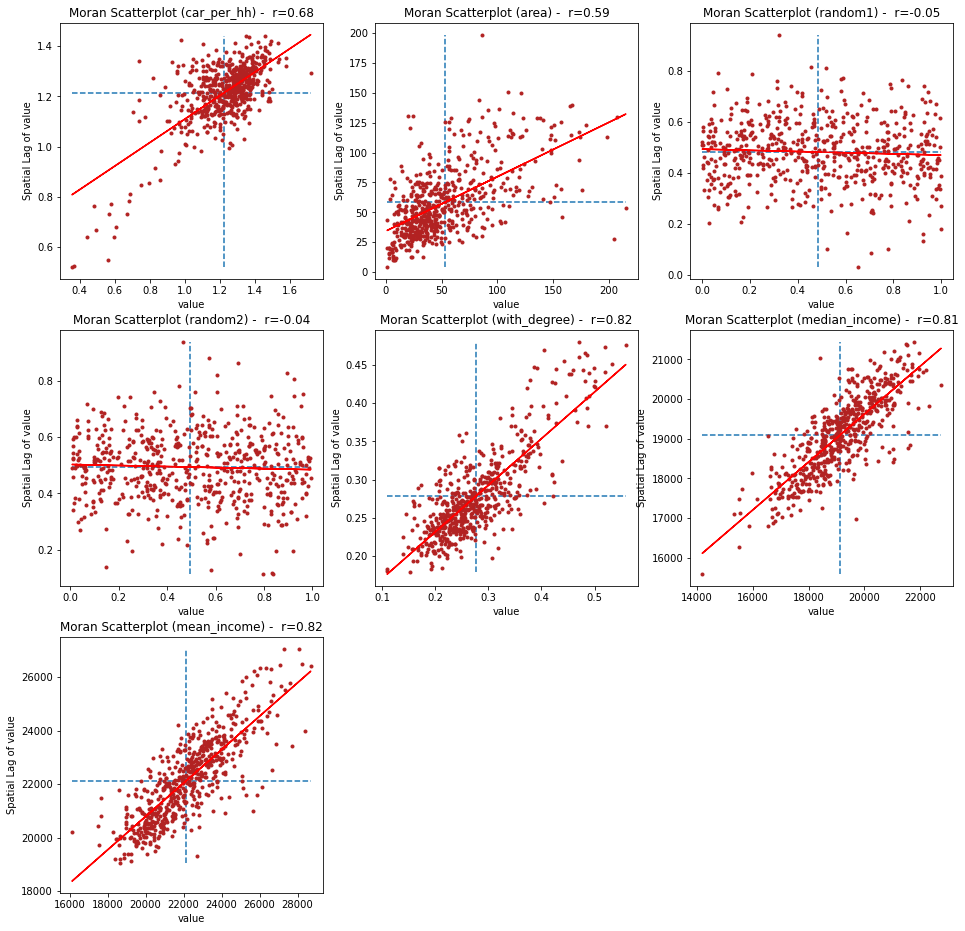

In [123]:
d_col = data_columns# ["random1", "mean_income"]
# d_col = ["random2", "area", "mean_income"]
f, ax = plt.subplots(len(d_col)//3+1, 3, 
#                      figsize=(16, 8), 
                     figsize=(16, 16), 
                     squeeze=False)
ax = ax.flatten()
for i, v in enumerate(d_col):
    
    b, a = np.polyfit(data[v], ylag[v], 1)
   
    pearson_r = np.corrcoef(data[v], ylag[v])[0][1]


    ax[i].plot(data[v], ylag[v], '.', color='firebrick')

    # dashed vert at mean of the value
    ax[i].vlines(data[v].mean(), ylag[v].min(), ylag[v].max(), linestyle='--')

    # dashed horizontal at mean of lagged value 
    ax[i].hlines(ylag[v].mean(), data[v].min(), data[v].max(), linestyle='--')

    # red line of best fit using global I as slope
    ax[i].plot(data[v], a + b*data[v], 'r')
    ax[i].set_title(f'Moran Scatterplot ({v}) -  r={pearson_r:.2f}')
    ax[i].set_ylabel('Spatial Lag of value')
    ax[i].set_xlabel('value')

for i in range(i+1, len(ax)):
    ax[i].set_axis_off()
    
plt.savefig(f'{outputpath}/spatial_lag.png', dpi=150,  bbox_inches='tight')

# Global spatial autocorrelation

With the global spatial autocorrelation, we'll caracterize the autocorrelation of a metric with on single value, which basicaly tells how this variable behaves regarding a fully random metric attribution.

We'll first present a simplified vue, where the continuous range of value is converted to a binary value. We then generalize by a fully continuous variable 

## Binary

Each value is converted to "0" (Low, of White) if below the median, 1 (High, Black) otherwise. Works well if the median cuts the dataset into to roughly even parts, but not if there are many identical values

In [124]:
yb = {v: data[v] > data[v].median() for v in data_columns}
#yb

In [125]:
for v in data_columns:
    labels = ["0 Low", "1 High"]

    data[v+'_yb'] = [labels[i] for i in 1*yb[v]] 
# data

In [126]:
# yb

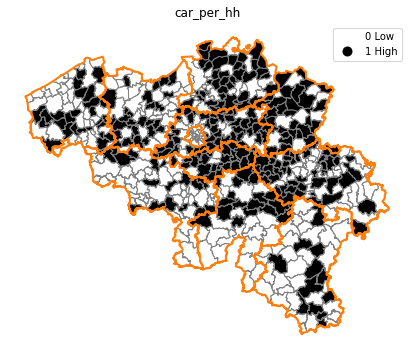

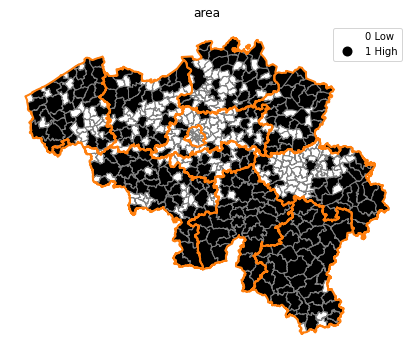

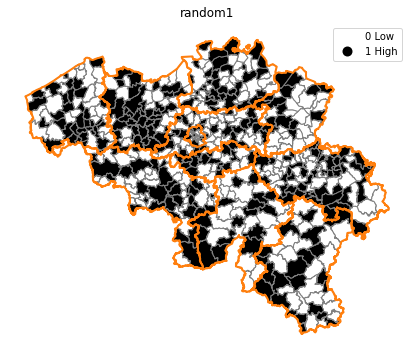

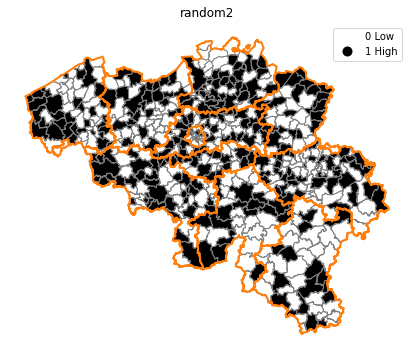

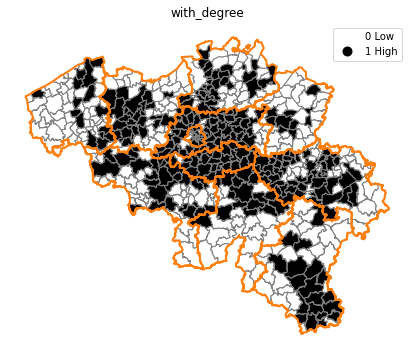

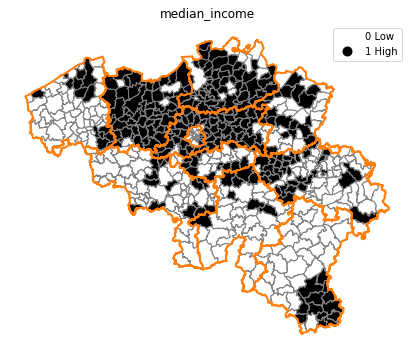

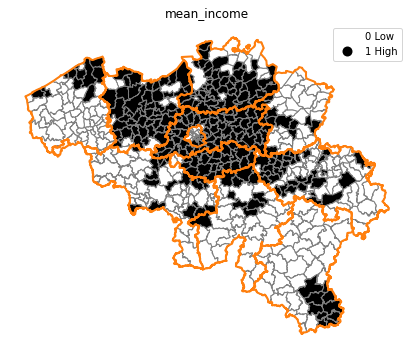

In [141]:
for v in data_columns:
    #fig = plt.figure(figsize=(12,10))
    fig = plt.figure(figsize=(8,6))
    ax = plt.gca()
    data.plot(column=v+'_yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)
    #ax.set_facecolor('lightgrey')
    plt.axis("off")
    extra_bounds.boundary.plot(ax=ax, color='C1', linewidth=2)
    ax.set_title(v)

## Join cuts

The "Join_Counts" methods counts =
- bb: how many "black-black" joins we have (black sector touching another black sector)
- mean_bb: how many "black-black" joins we would have if the value was random
- sim_bb: many (default: 999) "black-black joins counts" obtained on random tests

In [128]:
wq =  lp.weights.Queen.from_dataframe(data)
wq.transform = 'b'
np.random.seed(12345)

jc = {}
yb = {}
for v in data_columns:
    yb[v] = 1 * (data[v] > data[v].median()) # convert back to binary
    # print(yb[v].value_counts())
    jc[v] = esda.join_counts.Join_Counts(yb[v], wq)
    print(f"{v:20}: BB counts: {jc[v].bb} - Average BB count: {jc[v].mean_bb}")

car_per_hh          : BB counts: 470.0 - Average BB count: 408.07507507507506
area                : BB counts: 580.0 - Average BB count: 408.78678678678676
random1             : BB counts: 400.0 - Average BB count: 408.45745745745745
random2             : BB counts: 399.0 - Average BB count: 409.66366366366367
with_degree         : BB counts: 601.0 - Average BB count: 408.94794794794797
median_income       : BB counts: 619.0 - Average BB count: 408.92392392392395
mean_income         : BB counts: 646.0 - Average BB count: 407.60360360360363


We plot here the distribution of the number of black-black joins counts for random runs for the same geography (blue bell), 
as well as the the number of black-black joins for each of the metrics (red vertical lines)



car_per_hh: 470.0
area: 580.0
random1: 400.0
random2: 399.0
with_degree: 601.0
median_income: 619.0
mean_income: 646.0


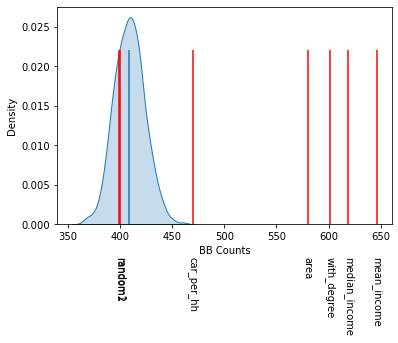

In [129]:
ax = sbn.kdeplot(np.array(jc[data_columns[1]].sim_bb, dtype = float), shade=True)
ylim =  ax.get_ylim()[1]*0.8
trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
# sbn.displot(jc.sim_bb)
plt.vlines(jc[data_columns[1]].mean_bb, 0,ylim)

plt.xlabel('BB Counts')
for v in data_columns:
    plt.vlines(jc[v].bb, 0, ylim, color='r')
    plt.text(jc[v].bb, -.15, v, rotation=-90, va="top", ha="center", transform=trans)
    
    print(f"{v}: {jc[v].bb}")

plt.savefig(f'{outputpath}/join_cuts.png', dpi=150,  bbox_inches='tight')

## Continuous case

In [130]:
wq.transform = 'r'

In [131]:
np.random.seed(12345)
mi = {v: esda.moran.Moran(data[v], wq) for v in data_columns}
{mi[v].I for v in data_columns}

{-0.023167440718124634,
 -0.018536500442232807,
 0.454426170634088,
 0.46739259936585914,
 0.6048241068575431,
 0.6123133157665215,
 0.6247367889465636}

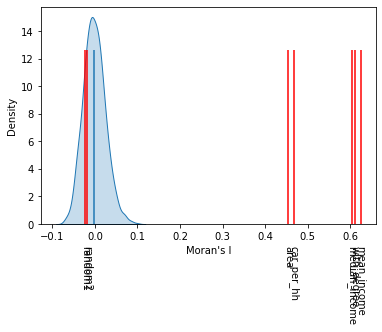

In [132]:
ax = sbn.kdeplot(mi[data_columns[1]].sim, shade=True)
trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)

plt.vlines(mi[data_columns[0]].EI, 0, 0.8 , transform=trans)

plt.xlabel("Moran's I")
for v in data_columns:
     plt.vlines(mi[v].I, 0, 0.8,  color='r', transform=trans)
     plt.text(mi[v].I, -0.1, v, rotation = -90, va = "top", ha = "center", transform=trans)



# Local autocorrelation

In [133]:
np.median(ylag[v])

22036.6

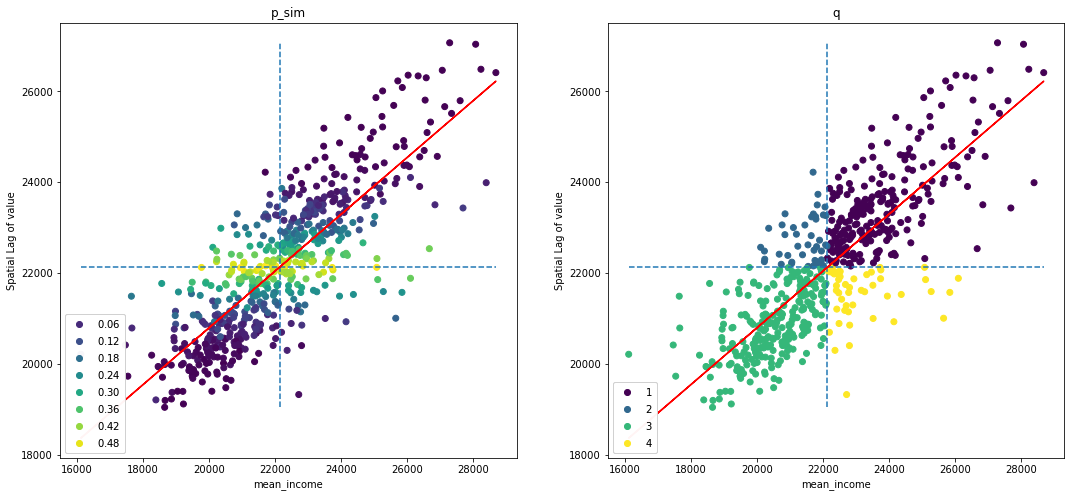

In [140]:
v="mean_income"
b, a = np.polyfit(data[v], ylag[v], 1)
f, axes = plt.subplots(1, 2, figsize=(18, 8))

li = esda.moran.Moran_Local(data[v], wq)
scatters=[None]*2

scatters[0] =axes[0].scatter(data[v], ylag[v], c=li.p_sim)
axes[0].set_title("p_sim")

scatters[1] =axes[1].scatter(data[v], ylag[v], c=li.q)
axes[1].set_title("q")

for i in range(2):
    lgd = axes[i].legend(*scatters[i].legend_elements(),
                    loc="lower left")
    axes[i].add_artist(lgd)

for ax in axes.flatten():
 # dashed vert at mean of the value
    ax.vlines(np.mean(data[v]), ylag[v].min(), ylag[v].max(), linestyle='--')
     # dashed horizontal at mean of lagged value 
    ax.hlines(np.mean(ylag[v]), data[v].min(), data[v].max(), linestyle='--')

    # red line of best fit using global I as slope
    ax.plot(data[v], a + b*data[v], 'r')
    
    ax.set_ylabel('Spatial Lag of value')
    ax.set_xlabel(v)
plt.show()


In [135]:
sig = 1 * (li.p_sim < 0.07)
hotspot  = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond  = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond


In [136]:
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]


In [137]:
# ax.legend_elements()

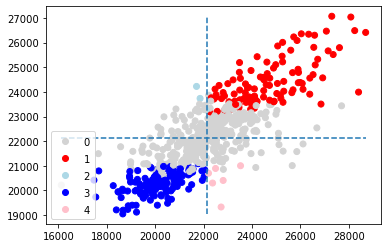

In [138]:
color = (li.p_sim < 0.07) * li.q

hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])

ax=plt.scatter(data[v], ylag[v], c=color, cmap=hmap, label=labels)

plt.legend(*ax.legend_elements(), loc="lower left")

plt.vlines(np.mean(data[v]), ylag[v].min(), ylag[v].max(), linestyle='--')
# dashed horizontal at mean of lagged value 
plt.hlines(np.mean(ylag[v]), data[v].min(), data[v].max(), linestyle='--')

# plt.legend(loc="lower left")
plt.show()

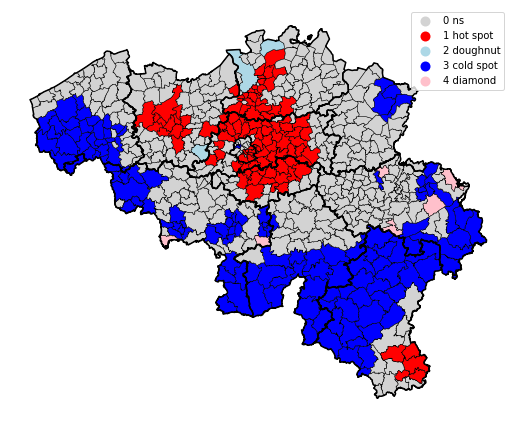

In [139]:
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(9, 9))
data.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.5, ax=ax, \
        edgecolor='k', legend=True)
extra_bounds.boundary.plot(ax=ax, color='k')
ax.set_axis_off()
plt.show()